In [1]:
from utils import *
import pickle
import pandas as pd
import os
import itertools
import bisect
from collections import Counter

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.interpolate import RectBivariateSpline
from scipy.stats import wasserstein_distance
from scipy.stats import gaussian_kde

from statsmodels.tsa.stattools import adfuller
from scipy.stats import ks_2samp

import numpy as np
from scipy.optimize import minimize, basinhopping

from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

## Testing

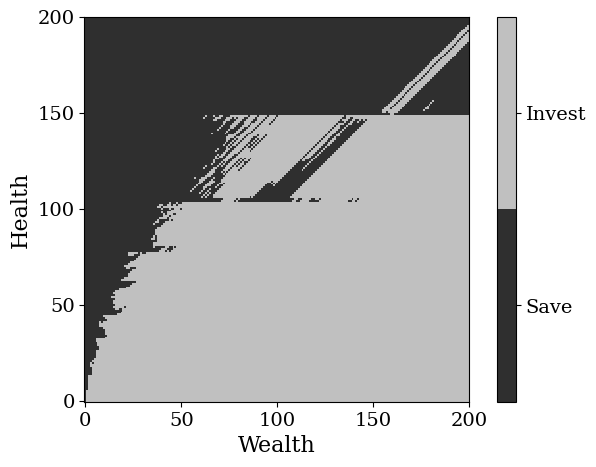

In [2]:
policy, params, V = value_iteration(

    N=200,
    theta=0.88,
    beta=0.95,

    omega=2.6,
    eta=0.75,
    alpha=0.45,
    w_delta_scale=0.5,
    P_H_increase=0.7,
    P_H_decrease=0.5,
    gamma=0.6

)

plot_policy_boundary(policy, params, savepath="policy_boundary.pdf", colors=["#2f2f2f", "#c0c0c0"])

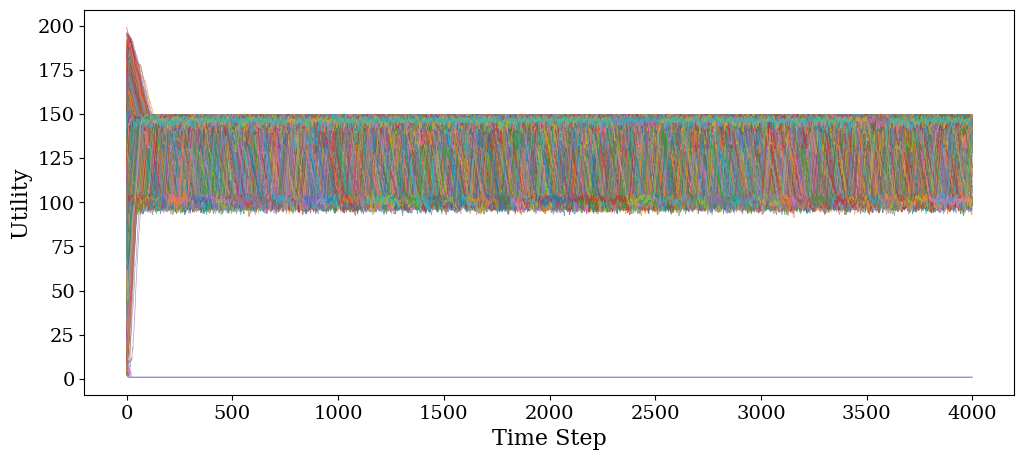

In [3]:
wealth, health = simulate(
    params,
    policy,
    num_steps = 4000,
    num_agents = 2000
)

util = utility(wealth, health, alpha=params["alpha"])
plot_utility_trajectories(util)

## Results

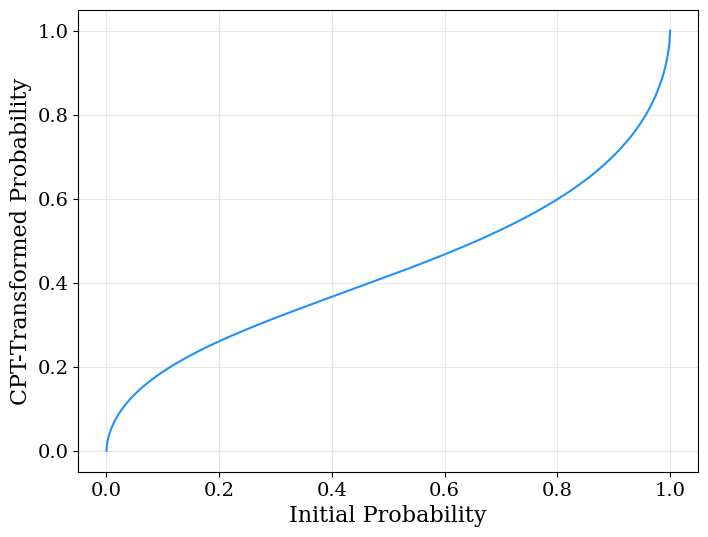

In [10]:
x = np.linspace(0,1,1000)
y = probability_weighting(x, gamma=0.6)
plt.plot(x, y, color="dodgerblue")
plt.grid()
plt.xlabel("Initial Probability")
plt.ylabel("CPT-Transformed Probability")
plt.savefig("cpt_probability.pdf", bbox_inches="tight")

In [2]:
# filepath = "results/0.5568190175603988_1_3_0.67.pickle"
# filepath = "results/0.22281696517478075_2_4_1.0.pickle"
# filepath = "results/0.9609052284742076_1_1_1.0.pickle"
# filepath = "results/0.6563071838844773_5_5_1.0.pickle"
# filepath = "results/0.00048207227921866387_10_9_1.0.pickle"
# filepath = "results/0.9714893658039508_7_2_1.0.pickle"
filepath = "results/0.00897387435627072_1_3_1.0.pickle"

filepath = "results/0.6270616215851346_2_3_1.0.pickle"

with open(filepath, "rb") as f:
    res = pickle.load(f)
wealth = res["wealth"]
health = res["health"]

util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])

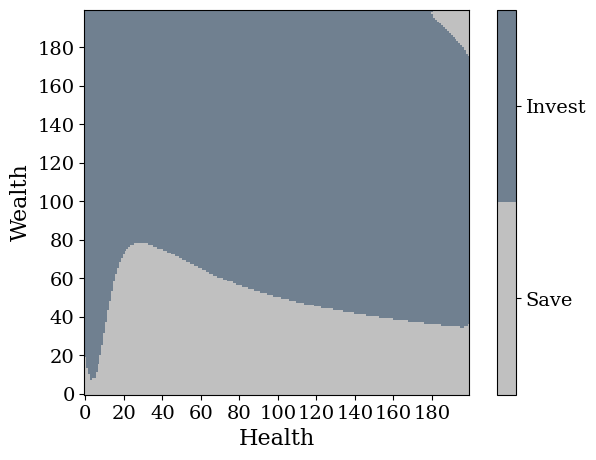

In [5]:
plot_policy_boundary(res["policy"], res["params"], savepath="policy_boundary.pdf", colors=["silver", "slategrey"])
# plot_utility_trajectories(util)

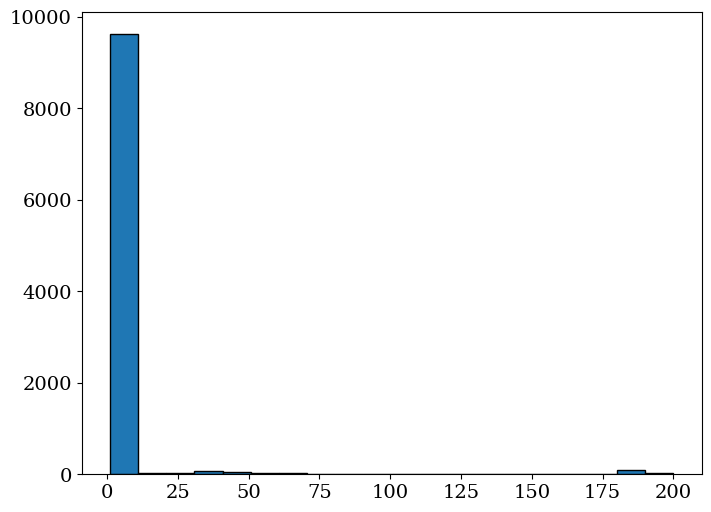

In [198]:
plt.hist(util[:,-1], bins=20, edgecolor='k')
plt.show()

## Steady State

In [2]:
result_suffix = '5'

In [3]:
def adf_stationarity_test(data, t1=1000):
    mean_series = data[:,t1:].mean(axis=0)
    if np.diff(mean_series).sum() == 0:
        return 1
    result = adfuller(mean_series)
    return int(result[1] < 0.05) 

def ks_test_convergence(data, t1=4500, t2=-1):
    ks_stat, p_value = ks_2samp(data[:, t1], data[:, t2])
    return int(p_value > 0.05)

def wasserstein_convergence(data):
    distances = []
    for t in range(data.shape[1]-1):
        dist = wasserstein_distance(data[:, t], data[:, t + 1])
        distances.append(dist)
    return np.array(distances)

In [311]:
wass = {}
for item in tqdm(os.listdir("results_"+result_suffix)):
    with open("results_"+result_suffix+"/"+item, "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"][:,-500:], res["health"][:,-500:], alpha=res['params']['alpha'])
    wass[item] = wasserstein_convergence(util)

with open(f"wasserstein_distances_{result_suffix}.pickle", "wb") as f:
    pickle.dump(wass, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [27]:
with open(f"wasserstein_distances_{result_suffix}.pickle", "rb") as f:
    wass = pickle.load(f)

In [105]:
item = list(wass.keys())[np.argmax(stack.max(axis=1))]
with open("results_"+result_suffix+"/"+item, "rb") as f:
    res = pickle.load(f)
util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])

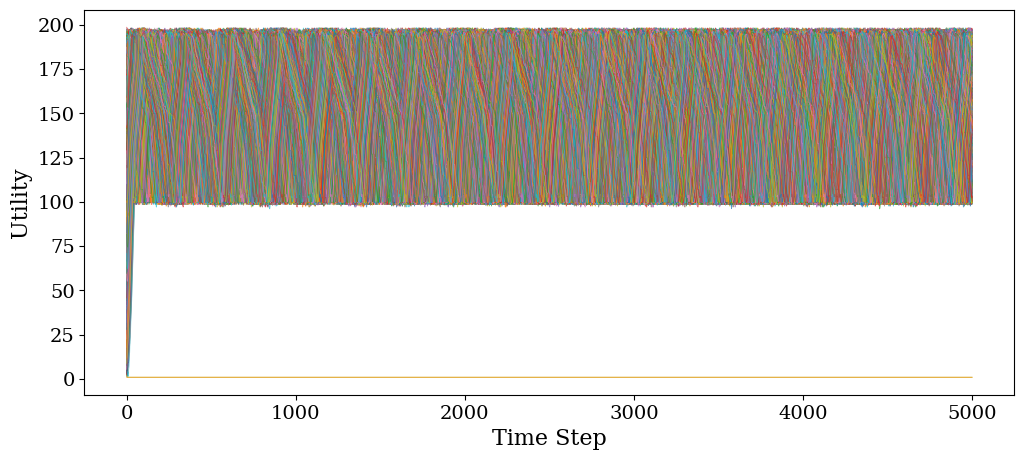

In [106]:
plot_utility_trajectories(util)

In [116]:
dd = {}
for idx,x in enumerate([item, list(wass.keys())[0]]):
    with open("results_"+result_suffix+"/"+x, "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    distances = []
    for t in range(util.shape[1]-1):
        dist = wasserstein_distance(util[:, t], util[:, t + 1])
        distances.append(dist)
    dd[x] = distances

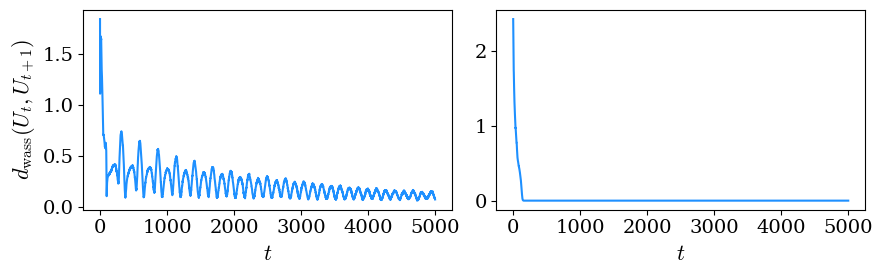

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(9,3))
axs[0].plot(dd[list(dd.keys())[0]], c="dodgerblue")
axs[0].set_ylabel(r"$d_{\text{wass}} (U_t, U_{t+1})$")
axs[0].set_xlabel(r"$t$")
axs[1].plot(dd[list(dd.keys())[1]], c="dodgerblue")
axs[1].set_xlabel(r"$t$")
fig.tight_layout()
plt.savefig("wasserstein_convergence.pdf", bbox_inches="tight")
plt.show()

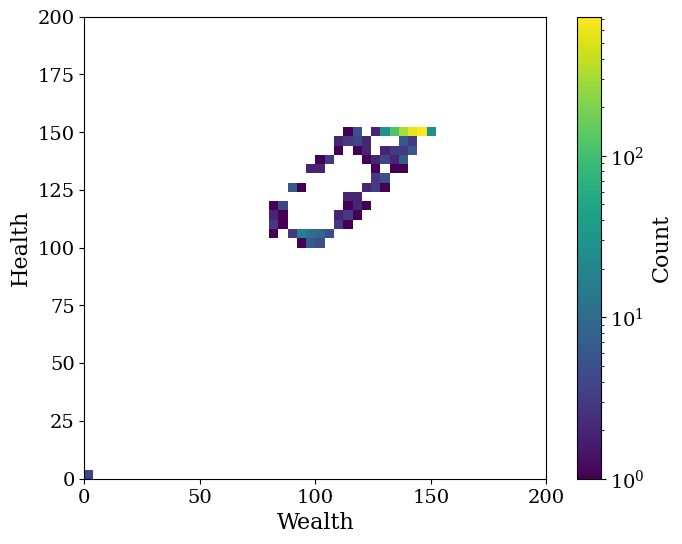

In [4]:
hist, xedges, yedges = np.histogram2d(wealth[:,-1], health[:,-1], bins=50, range=[(0,200), (0,200)])
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], norm="log")
plt.colorbar(label='Count')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.show()

In [5]:
# compute density and potential
density = hist / np.sum(hist)
with np.errstate(divide='ignore'):
    potential = -np.log(density)
    potential[np.isinf(potential)] = np.nan

# interpolation function
max_finite_value = np.nanmax(potential)
potential[np.isnan(potential)] = max_finite_value + 1
smoothed_potential = gaussian_filter(potential, sigma=1)

interp_func = RectBivariateSpline(np.linspace(0,199,len(xedges)-1), np.linspace(0,199,len(xedges)-1), smoothed_potential)
INTERPOLATION = np.zeros((200,200))
for i,x in enumerate(np.linspace(0, 199, 200)):
    for j,y in enumerate(np.linspace(0, 199, 200)):
        potential_at_point = interp_func(x, y)[0, 0]
        INTERPOLATION[i][j] = potential_at_point

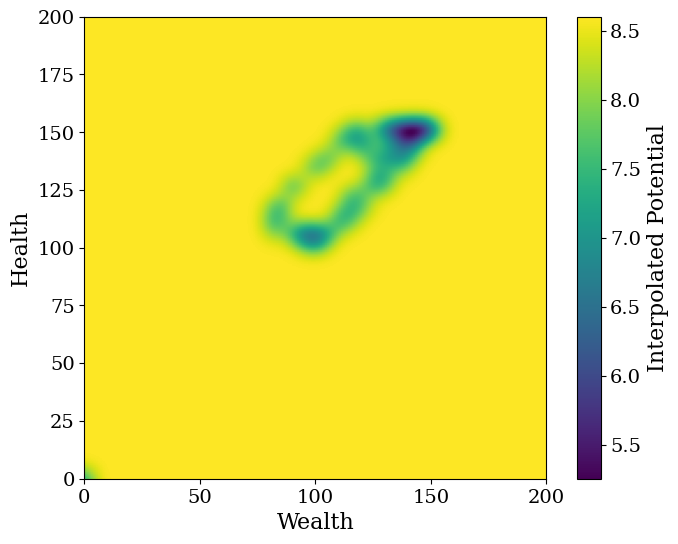

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(INTERPOLATION.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Interpolated Potential')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.savefig("steady_state_potential.pdf", bbox_inches="tight")
plt.show()

## Mean First Passage Time (MFPT)

In [219]:
def compute_MFPT(n_steps, n_simulations, start_pos, target_pos, step_size, interpolate):
    rand_nums = np.random.uniform(0, 1, size=(n_steps, n_simulations))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps, n_simulations))

    target_x = np.full(n_simulations, target_pos[0])
    target_y = np.full(n_simulations, target_pos[1])

    X = np.zeros((n_simulations, n_steps+1))
    X[:,0] = start_pos[0]
    Y = np.zeros((n_simulations, n_steps+1))
    Y[:,0] = start_pos[1]

    still_moving = np.ones((n_simulations,))
    FPT = np.full_like(np.zeros(n_simulations,), n_steps)
    
    current_potential = interpolate(X[:,0], Y[:,0], grid=False)

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size
        new_potential = interpolate(X[:,step] + dx, Y[:,step] + dy, grid=False)

        # check whether to accept or reject moves
        accept = np.logical_or(new_potential < current_potential, rand_nums[step] < np.exp(current_potential - new_potential))
        current_potential = new_potential

        # update position
        X[:,step+1] = X[:,step] + accept * dx * still_moving
        Y[:,step+1] = Y[:,step] + accept * dy * still_moving

        reached_target = (X[:,step+1] - target_x)**2 + (Y[:,step+1] - target_y)**2 < step_size**2
        FPT = np.where(np.logical_and(still_moving, reached_target), step, FPT)
        still_moving = np.where(reached_target, 0, still_moving)

        if not np.any(still_moving):
            break

    return FPT.mean()


def compute_MFPT_region(n_steps, n_simulations, start_pos, step_size, interpolate, x_bounds=(75, 100), y_bounds=(75, 100)):
    rand_nums = np.random.uniform(0, 1, size=(n_steps, n_simulations))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps, n_simulations))

    X = np.zeros((n_simulations, n_steps+1))
    X[:,0] = start_pos[0]
    Y = np.zeros((n_simulations, n_steps+1))
    Y[:,0] = start_pos[1]

    still_moving = np.ones((n_simulations,))
    FPT = np.full_like(np.zeros(n_simulations,), n_steps)
    
    current_potential = interpolate(X[:,0], Y[:,0], grid=False)

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size
        new_potential = interpolate(X[:,step] + dx, Y[:,step] + dy, grid=False)

        # Check whether to accept or reject moves
        accept = np.logical_or(new_potential < current_potential, rand_nums[step] < np.exp(current_potential - new_potential))
        current_potential = new_potential

        # Update position
        X[:,step+1] = X[:,step] + accept * dx * still_moving
        Y[:,step+1] = Y[:,step] + accept * dy * still_moving

        # Check if the walker is within the target region
        within_region = np.logical_and.reduce((
            X[:,step+1] > x_bounds[0], X[:,step+1] < x_bounds[1],
            Y[:,step+1] > y_bounds[0], Y[:,step+1] < y_bounds[1]
        ))
        FPT = np.where(np.logical_and(still_moving, within_region), step, FPT)
        still_moving = np.where(within_region, 0, still_moving)

        if not np.any(still_moving):
            break

    return FPT.mean()

In [23]:
compute_MFPT_region(1000, 1000, (15,15), 1, interp_func, x_bounds=(75, 200), y_bounds=(150, 200))

np.float64(1000.0)

In [3]:
def map_float_to_int(x, A, B):
    return np.floor(x * (B - A + 1)) + A

N = 10
lh = LatinHypercube(d=2)
lower_sample = lh.random(n=N)
lower_sample = map_float_to_int(lower_sample, 1, 20).astype(int)

n_steps = 1000
n_simulations = 1000
overall_mftp = {}

for item in tqdm(os.listdir("results")):
    param_list = item.split(".pickle")[0].split("_")
    param_tuple = tuple([float(p) for p in param_list])
    
    with open("results/"+item, "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    interpolation_function = get_interpolation_function(wealth[:,-1], health[:,-1])

    mftp = []
    for p1 in lower_sample:
        mftp.append(
            compute_MFPT_region(
                n_steps, n_simulations, p1, step_size=1, interpolate=interpolation_function
            )
        )
    overall_mftp[param_tuple] = mftp

  0%|          | 0/512 [00:00<?, ?it/s]

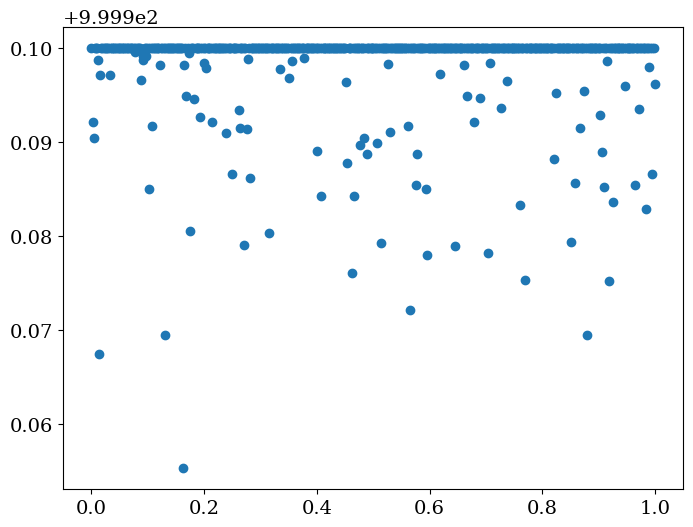

In [9]:
keys = list(overall_mftp.keys())
alphas = np.array([k[0] for k in keys])
plt.scatter(alphas, [np.mean(overall_mftp[k]) for k in overall_mftp])
plt.show()

In [6]:
with open("mftp_results.pickle", "wb") as f:
    pickle.dump(overall_mftp, f)

## Extracting Traps / Minima

In [2]:
interpolation_functions = {}
for item in tqdm(os.listdir("results")):
    with open("results/"+item, 'rb') as f:
        res = pickle.load(f)
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )
    interpolation_functions[item] = interp_func

with open("interpolation_functions.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [15]:
MINIMA = {}
for key, func in tqdm(interpolation_functions.items()):
    MINIMA[key] = get_minima(func, count_threshold=2, num_points=20)

with open("mninima.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [73]:
# with open("mninima.pickle", "rb") as f:
#     MINIMA = pickle.load(f)

In [204]:
cutoff_distance = 15
cutoff_count = 4
final = {}

for key, points in tqdm(MINIMA.items()):
    keep_points = []
    for i in range(len(points)):
        keep = True
        x1, y1 = points[i][0]
        for j in range(len(points)):
            if i == j:
                continue
            x2, y2 = points[j][0]
            if points[j][1] > points[i][1]:
                if np.sqrt((x2 - x1)**2 + (y2 - y1)**2) <= cutoff_distance:
                    keep = False
                    break
        if keep and points[i][1] >= cutoff_count:
            keep_points.append(points[i])
    final[key] = keep_points

  0%|          | 0/512 [00:00<?, ?it/s]

In [250]:
num_steps = 1000
num_simulations = 1000
step_size = 1
cleaned_minima = {}

for item in tqdm(os.listdir("results")):
    cleaned_minima[item] = {}
    with open("results/"+item, 'rb') as f:
        res = pickle.load(f)
    wealth, health = res["wealth"][:,-1], res["health"][:,-1]
    util = sorted(utility(wealth, health, alpha=res['params']['alpha']))

    min_points = final[item]
    for p in min_points:
        x, y = p[0]
        x = float(max(x, 1))
        y = float(max(y, 1))
        p_util = utility(x, y, alpha=res["params"]["alpha"])
        util_idx = bisect.bisect_left(util, p_util)
        percentile = util_idx / (len(util) + 1)
        cleaned_minima[item][(x,y)] = {
            "count": p[1],
            "util_percentile": percentile
        }

    mfpt_values = []
    for p1 in min_points:
        x1, y1 = p1[0]
        for p2 in min_points:
            if p1 == p2:
                continue
            x2, y2 = p2[0]
            mfpt = compute_MFPT(num_steps, num_simulations, (x1,y1), (x2,y2), step_size, interpolation_functions[item])
            mfpt_values.append(
                ((x1,y2), (x2,y2), mfpt)
            )
    cleaned_minima[item]["mfpt"] = mfpt_values

  0%|          | 0/512 [00:00<?, ?it/s]

In [251]:
with open("minima_metrics.pickle", "wb") as f:
    pickle.dump(cleaned_minima, f)

In [7]:
minima = get_minima(interp_func, count_threshold=2, num_points=15, step_size=10)

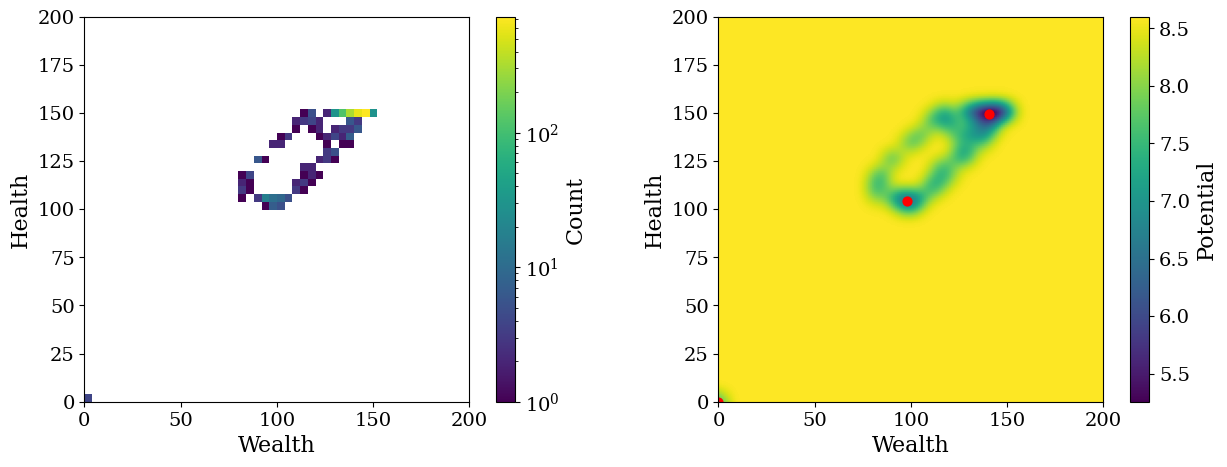

In [8]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

cmap1 = ax[0].imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], norm="log")
plt.colorbar(cmap1, ax=ax[0], orientation='vertical', label="Count")
ax[0].set_xlabel('Wealth')
ax[0].set_ylabel('Health')

cmap2 = ax[1].imshow(INTERPOLATION.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
for point, count in minima:
    if count >= 4:
        ax[1].scatter([point[0]], [point[1]], c="red", s=40)
plt.colorbar(cmap2, ax=ax[1], orientation='vertical', label="Potential")
ax[1].set_xlabel('Wealth')
ax[1].set_ylabel('Health')
plt.savefig("steady_state_potential.pdf", bbox_inches="tight")
plt.show()

In [18]:
# for i in range(len(minima)):
#     mi = minima[i][0]
#     for j in range(i+1, len(minima)):
#         mj = minima[j][0]
#         mftp = compute_MFPT(1000, 10000, minima[i][0], minima[j][0], 1, interp_func)
#         print((float(mi[0]), float(mi[1])), (float(mj[0]), float(mj[1])), mftp)

## Agent decisions / repeating sequences

In [23]:
adjusted_wealth = wealth - 1
adjusted_health = health - 1
indices = np.stack([adjusted_wealth, adjusted_health], axis=-1)
decisions = res["policy"][indices[..., 0], indices[..., 1]]

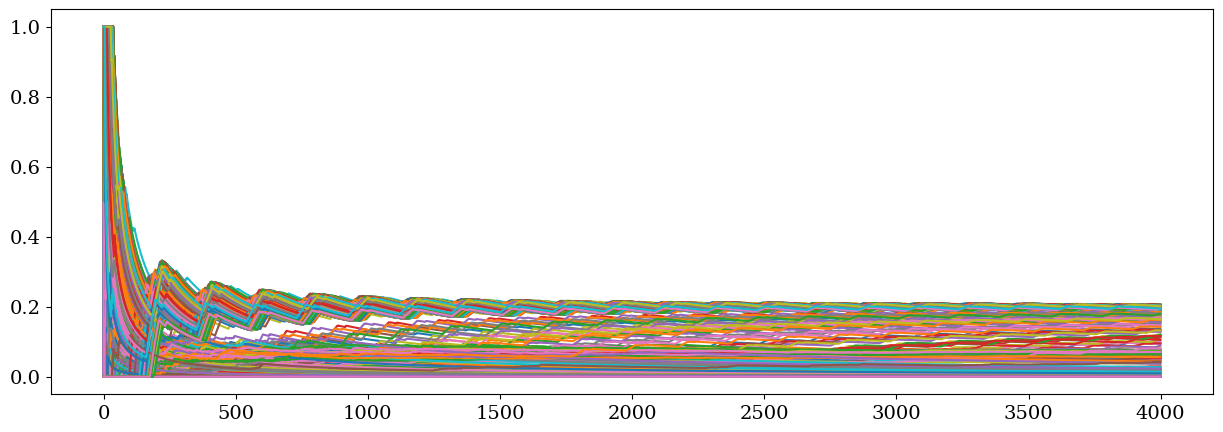

In [24]:
cum_mean = np.cumsum(decisions, axis=1) / (np.arange(0,decisions.shape[1])+1)
plt.figure(figsize=(15, 5))
plt.plot(cum_mean.T)
plt.show()

In [2]:
def find_stable_time(signal, threshold, window):
    """
    Find the time step where the signal has not left a bounding interval of size `threshold` within the last `window` steps.
    Parameters:
        signal (array-like): 1D array representing the signal values over time.
        threshold (float): The size of the bounding interval.
        window (int): The number of steps in the sliding window.
    Returns:
        int: The time step where the condition is first met (-1 if no such step exists).
    """
    for t in range(window, len(signal)):
        window_values = signal[t:t + window]
        if np.max(window_values) - np.min(window_values) <= threshold:
            return t
    return -1

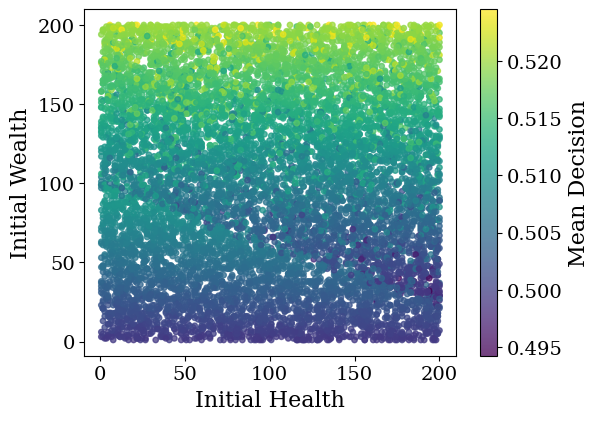

In [15]:
plt.figure(figsize=(6, 4.5))

T = -1

scatter = plt.scatter(
    health[:, 0], wealth[:, 0], 
    c=cum_mean[:, T], 
    cmap='viridis', 
    norm=Normalize(vmin=cum_mean[:,T].min(), vmax=cum_mean[:,T].max()), 
    s=15,
    alpha=0.75
)

plt.colorbar(scatter, label='Mean Decision')    
plt.xlabel("Initial Health")
plt.ylabel("Initial Wealth")
plt.show()

In [26]:
zero_sequence = []
alt_sequence =  []
one_sequence =  []

L = 50

start_idx = 0

alt10 = np.tile([1, 0], L // 2 + 1)[:L]
alt01 = np.tile([0, 1], L // 2 + 1)[:L]

cumulative = np.cumsum(decisions, axis=1)

# Iterate over each agent
for agent in tqdm(range(decisions.shape[0])):
    d = decisions[agent, :]
    cumsum = cumulative[agent, :]    

    for i in range(start_idx, len(d) - L + 1):
        # Compute the sum of the window [i:i+L]
        sum_L = cumsum[i + L - 1] - (cumsum[i - 1] if i > 0 else 0)

        # Check for sequences of L zeros (sum = 0) or L ones (sum = L)
        if sum_L == 0:
            zero_sequence.append(agent)
            break

        if sum_L == L:
            one_sequence.append(agent)
            break

        # Check for alternating sequences
        if np.array_equal(d[i:i+L], alt10) or np.array_equal(d[i:i+L], alt01):
            alt_sequence.append(agent)
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
len(zero_sequence), len(one_sequence), len(alt_sequence)

(3300, 4390, 2309)

In [28]:
len(zero_sequence) + len(one_sequence) + len(alt_sequence)

9999

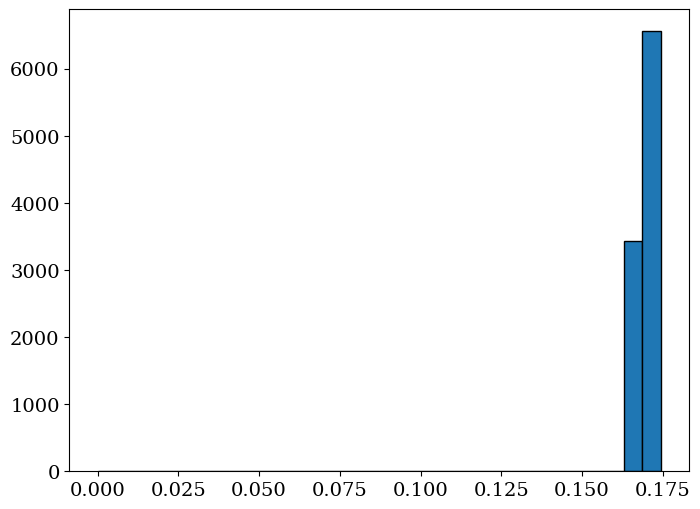

In [45]:
plt.hist(np.mean(decisions, axis=1), bins=30, edgecolor="k")
plt.show()

In [135]:
plt.figure(figsize=(6,5.5))
plt.scatter(health[np.array(zero_sequence), 0], wealth[np.array(zero_sequence), 0], c="r", s=5, label=r"$\overline{0}$")
plt.scatter(health[np.array(one_sequence), 0], wealth[np.array(one_sequence), 0], c="b", s=5, label=r"$\overline{1}$")
plt.scatter(health[np.array(alt_sequence), 0], wealth[np.array(alt_sequence), 0], c="g", s=5, label=r"$\overline{01}$")

plt.legend(bbox_to_anchor=(1,1), shadow=True)
plt.xlabel("Initial Health")
plt.ylabel("Initial Wealth")
plt.show()

NameError: name 'health' is not defined

<Figure size 600x550 with 0 Axes>

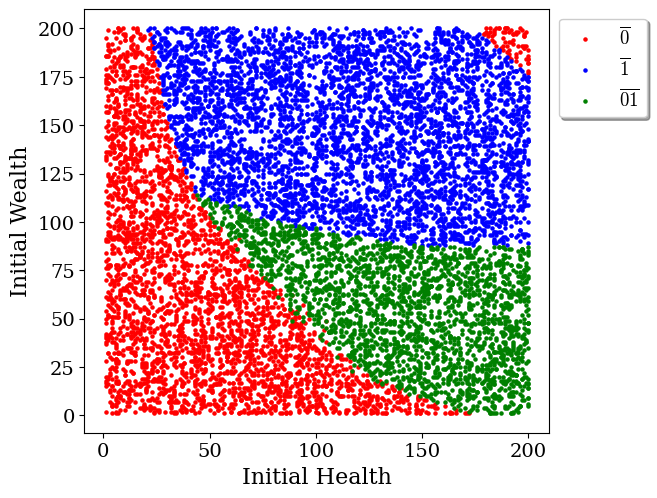

In [29]:
plt.figure(figsize=(6,5.5))
plt.scatter(health[np.array(zero_sequence), 0], wealth[np.array(zero_sequence), 0], c="r", s=5, label=r"$\overline{0}$")
plt.scatter(health[np.array(one_sequence), 0], wealth[np.array(one_sequence), 0], c="b", s=5, label=r"$\overline{1}$")
plt.scatter(health[np.array(alt_sequence), 0], wealth[np.array(alt_sequence), 0], c="g", s=5, label=r"$\overline{01}$")

plt.legend(bbox_to_anchor=(1,1), shadow=True)
plt.xlabel("Initial Health")
plt.ylabel("Initial Wealth")
plt.show()